# Energy Estimator Tool
## Introduction
This is a port of the enVerid COVID-19 Energy Estimator 2 Excel Spreadsheet to a Jupyter Notebook to better understand the calculation methods the spreadsheet.

The spreadsheet must be present in the same folder folder as this file for the reference tables to be read.

### Abbreviations
- oa or OA: Outside/Outdoor Air
- occ or OCC: Occupancy
- vrp or VRP: Ventilation Rate Procedure
- iaqp or IAQP: Indoor Air Quality Procedure
- ach or ACH: Air Changes per Hour
- cop or COP: Coefficient of Performance
- cadr or CADR: Clean Air Delivery Rate
- op / ops: Operating / Operations
- bldg: Building
- maint: Maintenance
- filt: Filter/Filtration
- vent: Ventilation
- CO2e: CO2 equivalent
- Ann.: Annual


## Reference Tables
The reference tables in the spreadsheet are also used in this notebook.

The following code imports the reference tables.

In [114]:
import pandas as pd

SPREADSHEET_PATH = "enVerid COVID-19 Energy Estimator 2.xlsx"

filters = pd.read_excel(
    SPREADSHEET_PATH, "Table 2 - Filtration Info", skiprows=2, skipfooter=4, index_col=1
).dropna(axis="columns")

# ASHRAE 62.1 2016 Outdoor Air rates (ref. table 6-1)
oa_rates = pd.read_excel(
    SPREADSHEET_PATH,
    "Table 3 - ASHRAE 62.1 OA Rates",
    header=1,
    index_col=0,
    names=["RPeople", "RArea"],
)

# Building operated 12 hours a day, 6 days a week.
operation_info_126 = pd.read_excel(
    SPREADSHEET_PATH, "Table 1 - Operational Info", header=3, nrows=21, index_col=1
)

# Building operated 24/7.
operation_info_247 = pd.read_excel(
    SPREADSHEET_PATH, "Table 1 - Operational Info", header=27, nrows=21, index_col=1
)

A next step to get away from the spreadsheet is to be able to generate this reference data for any location on a global scale. This spreadsheet is limited to a small set of U.S. cities.

## Calculation Classes

The following classes keep track of user inputs and calculate outputs. These classes replicate the calculations performed by the enVerid COVID Energy Estimator spreadsheet.

The `__post_init__` method runs after an instance of the class is created. This just allows for automatic calculation of values or for correcting values based on what was given to create the instance.

In [115]:
from dataclasses import dataclass


@dataclass
class GeneralInputs:
    """Class for keeping track of general inputs of building parameters."""

    city: str
    space_type: str
    floor_area: float  # sq ft
    avg_ceil_ht: float  # ft (average ceiling height)
    occupancy: float  # people
    total_supply_airflow: float  # CFM
    sys_vent_efficiency: float
    oa_calc_method: str  # VRP, VRP+30%, IAQP, or 100% OA
    outside_airflow_override = 0  # Allows for custom input (CFM)

    def __post_init__(self):
        self.volume = self.floor_area * self.avg_ceil_ht  # cu ft

    def vrp(self) -> float:
        """Calculate required airflow in CFM according to ventilation rate procedure (VRP)."""
        occ_component = self.occupancy * oa_rates["RPeople"].loc[self.space_type]  # CFM
        area_component = self.floor_area * oa_rates["RArea"].loc[self.space_type]  # CFM
        return (occ_component + area_component) / self.sys_vent_efficiency

    def outside_airflow(self) -> float:
        """Calculate required outside airflow (CFM) given the OA calculation method."""
        match self.oa_calc_method:
            case "VRP":
                return self.vrp()
            case "VRP+30%":
                return self.vrp() * 1.3
            case "IAQP":
                return self.floor_area * 0.05  # This is an arbitrary factor used in the spreadsheet.
            case "100% OA":
                return self.total_supply_airflow
            case "Other":
                return self.outside_airflow_override

    def outside_ach(self) -> float:
        """Calculate the outside air changes per hour."""
        air_changes_per_min = self.outside_airflow() / self.volume  # /min.
        return air_changes_per_min * 60  # /h

    def electricity_rate(self) -> float:
        """Return the cost of electricity from spreadsheet given the city."""
        return operation_info_126["Estimated Blended Electricity Rate ($/kWh)"].loc[
            self.city
        ]

In [116]:
@dataclass
class VentilationEnergyInputs:
    """Class for keeping track of ventilation energy inputs and costs."""

    oa_cooling_src = "Electricity"  
    oa_heating_src: str
    hrs_per_day_operation: float
    days_per_wk_operation: float
    cop: float
    heating_efficiency: float

    def hrs_per_wk_operation(self) -> float:
        """Calculate the hours per week the building in operation."""
        return self.hrs_per_day_operation * self.days_per_wk_operation

    def heating_energy_rate(self, gen: GeneralInputs) -> tuple[float | str, str]:
        """Calculate the cost of heating and a string of the pricing unit."""
        match self.oa_heating_src:
            case "Electricity":
                return gen.electricity_rate(), "$/kWh (blended)"
            case "Gas":
                heating_rate = operation_info_126["Gas Rate ($/therm)"].loc[gen.city]
                return heating_rate, "$/therm"
            case "Steam":
                heating_rate = operation_info_126["Steam Rate ($/Mlb)"].loc[gen.city]
                return heating_rate, "$/mmBTU"

In [117]:
@dataclass
class EnergyRecoveryInputs:
    """Class to keep track of the energy recovery usage."""

    is_used: bool
    summer_effectiveness: float
    winter_effectiveness: float

    def __post_init__(self):
        """Fix recovery effectivness to 0 if energy recovery is not used."""
        if not self.is_used:
            self.summer_effectiveness = 0
            self.winter_effectiveness = 0

In [118]:
@dataclass
class IndoorAirFiltrationInputs:
    """Class to keep track of indoor air filtration inputs and costs."""

    is_used: bool
    merv: str
    fan_efficiency: float
    mtr_efficiency: float
    max_filt_airspeed: float  # fpm
    filt_change_labor_cost: float  # $  ($12 install + $5 disposal)

    def avg_pressure_drop(self) -> float:
        """Return the average pressure drop across the filter in inches water."""
        return filters["average pressure drop (in.w.c.)"].loc[self.merv]

    def est_filter_lifespan(self) -> float:
        """Return the average estimated lifespan of the filter in months."""
        return filters["filter lifespan (months)"].loc[self.merv]

    def est_filter_cost(self) -> float:
        """Return the estimated cost ($) of a 24in. by 24in. filter."""
        return filters["cost"].loc[self.merv]

    def filtration_ach(self, bldg: GeneralInputs) -> float:
        """Return the air changes per hour supplied with recirculated air."""
        if self.is_used:
            recirc_airflow = bldg.total_supply_airflow - bldg.outside_airflow()  # CFM
            filt_eff = filters["Filter Efficiency (%)"].loc[self.merv]
            return recirc_airflow / (bldg.volume) * filt_eff * 60  # /h
        else:
            return 0
        

In [119]:
@dataclass
class AirCleanerInputs:
    """Class to keep track of air cleaner usage inputs and costs."""

    is_used: bool
    quantity: int  # Spreadsheet has 1 air cleaner per every 1000 sq ft
    supply_air_per_cleaner: float
    cadr_per_cleaner: float
    first_cost_per_cleaner: float  # Includes hardware + installation cost
    power: float
    est_lifespan_before_maint: float  # months
    labor_cost_maintenance: float  # $/unit
    matrl_cost_maintenance: float  # $/unit

    def __post_init__(self):
        """Set air cleaning power and zero values if air cleaning not used."""
        self.power = self.supply_air_per_cleaner * 0.0003  # kW / unit

        if not self.is_used:
            self.quantity = 0
            self.supply_air_per_cleaner = 0
            self.cadr_per_cleaner = 0

    def additional_ach(self, bldg: GeneralInputs) -> float:
        """Calculate additional air changes per hour provided by air cleaners."""
        if not self.is_used:
            return 0

        return self.cadr_per_cleaner * self.quantity / bldg.volume * 60

In [120]:
class OutsideAirVentilationCost:
    """Class to calculate annual cost and energy use from conditioning OA."""

    def __init__(
        self,
        bldg: GeneralInputs,
        ops: VentilationEnergyInputs,
        erv: EnergyRecoveryInputs,
    ):
        self.bldg = bldg
        self.ops = ops
        self.erv = erv

        # If the hours per week of operation is less than 24/7, the 12/6 data is used as a baseline.
        if self.ops.hrs_per_wk_operation() < (24 * 7):
            # 12 hrs per day, 6 days per week weather data used
            self.ops_info = operation_info_126
            self.weekly_op_hours_baseline = 72
        else:
            # Use weather data for 24/7 operation
            self.ops_info = operation_info_247
            self.weekly_op_hours_baseline = 168

    def cooling_oa_energy(self) -> float:
        """Calculate energy to cool outside air in kWh/yr."""
        # NOTE: The units for cooling energy data from the spreadsheet's operations table are truly kWh/cfm/yr.
        return (
            self.bldg.outside_airflow()
            * self.ops_info["Cooling energy (kWh/cfm)"].loc[self.bldg.city]
            * (1 - self.erv.summer_effectiveness)
            / (self.ops.cop / 3)  # A baseline COP of 3 was used in spreadsheet tables
            * (self.ops.hrs_per_wk_operation() / self.weekly_op_hours_baseline)
        )

    def annual_cooling_oa_cost(self) -> float:
        """Calculate cost to cool outside air in $/yr."""
        return self.cooling_oa_energy() * self.bldg.electricity_rate()

    def heating_oa_energy(self) -> tuple[float, str]:
        """Calculate energy to heat outside air in appropriate energy units per year."""
        match self.ops.oa_heating_src:
            case "Electricity":
                heating_energy = self.ops_info["Heating energy (kWh/cfm)"]
                unit = "kWh/yr"
            case "Gas":
                heating_energy = self.ops_info["Heating energy (therms/cfm)"]
                unit = "therm/yr"
            case "Steam":
                heating_energy = self.ops_info["Heating energy (mmBTU/cfm)"]
                unit = "mmBTU/yr"

        return (
            self.bldg.outside_airflow()
            * heating_energy.loc[self.bldg.city]
            * (1 - self.erv.winter_effectiveness)
            / self.ops.heating_efficiency
            * (self.ops.hrs_per_wk_operation() / self.weekly_op_hours_baseline),
            unit,
        )

    def annual_heating_oa_cost(self) -> float:
        """Calculate cost to heat outside air in $/yr."""
        energy_rate, _ = self.ops.heating_energy_rate(self.bldg)
        return self.heating_oa_energy()[0] * energy_rate

In [121]:
from math import ceil


class IndoorAirFiltrationCost:
    """Class to calculate annual cost and energy use from filtering indoor air."""

    def __init__(
        self,
        bldg: GeneralInputs,
        ops: VentilationEnergyInputs,
        filt: IndoorAirFiltrationInputs,
    ):
        self.bldg = bldg
        if filt.is_used:
            self.recirc_airflow = bldg.total_supply_airflow - bldg.outside_airflow()
        else:
            self.recirc_airflow = 0
        self.ops = ops
        self.filt = filt

    def filtration_fan_energy_load(self) -> float:
        """Calculate power load on the indoor air filtration fan in kW."""
        if not self.filt.is_used:
            return 0
        recirc_airflow_m3_per_h = self.recirc_airflow * 1.699  # CFM to m^3 per hour
        recirc_airflow_m3_per_s = recirc_airflow_m3_per_h / 3600
        avg_press_drop_pa = self.filt.avg_pressure_drop() * 248.84  # inches of water to pascal
        fan_load = (
            recirc_airflow_m3_per_s
            * avg_press_drop_pa
            / (self.filt.fan_efficiency * self.filt.mtr_efficiency)  # W
        )
        return fan_load / 1000  # kW

    def annual_fan_energy(self) -> float:
        """Calculate energy use by filtration fan in kWh/yr."""
        return self.filtration_fan_energy_load() * self.ops.hrs_per_wk_operation() * 52

    def annual_fan_energy_cost(self) -> float:
        """Calculate cost due to energy used by the filtration fan in $/yr."""
        return self.annual_fan_energy() * self.bldg.electricity_rate()

    def required_filter_quantity(self, filter_area_ft2) -> int:
        """Calculate number of filters needed with a given filter area in sq ft."""
        max_filt_airspeed_m_per_s = self.filt.max_filt_airspeed / 196.85
        recirc_airflow_m3_per_s = self.recirc_airflow * 1.699 / 3600
        req_filt_area_m2 = recirc_airflow_m3_per_s / max_filt_airspeed_m_per_s
        req_filt_area = req_filt_area_m2 * 10.7639  # sq ft

        # NOTE: The spreadsheet neglects this calculation, but the paper it references
        # (doi: 10.1016/j.buildenv.2013.08.025) says this is the procedure. As a result,
        # the spreadsheet costs are 4x higher than they should be for filter replacement costs!
        return ceil(req_filt_area / filter_area_ft2)

    def annual_material_cost(self) -> float:
        """Calculate cost due to replacing filters in $/yr."""
        changes_per_year = 12 / self.filt.est_filter_lifespan()
        # NOTE: Filter cost table uses 24" x 24" filters (4 sq ft)
        req_filters = self.required_filter_quantity(4)
        return changes_per_year * self.filt.est_filter_cost() * req_filters

    def annual_labor_cost(self) -> float:
        """Calculate cost due to labor involved in filter replacements in $/yr."""
        changes_per_year = 12 / self.filt.est_filter_lifespan()
        req_filters = self.required_filter_quantity(4)

        return changes_per_year * self.filt.filt_change_labor_cost * req_filters

    def annual_total_cost(self) -> float:
        """Calculate total cost of operating indoor air filtration in $/yr."""
        return (
            self.annual_fan_energy_cost()
            + self.annual_material_cost()
            + self.annual_labor_cost()
        )

In [122]:
class AirCleanerCost:
    """Class to calculate annual cost and energy consumption from air cleaners."""

    def __init__(
        self, bldg: GeneralInputs, ops: VentilationEnergyInputs, clean: AirCleanerInputs
    ):
        self.bldg = bldg
        self.ops = ops
        self.clean = clean

    def annual_energy(self) -> float:
        """Calculate the energy consumption of air cleaners in kWh/yr."""
        return (
            self.clean.power
            * self.clean.quantity
            * (self.ops.hrs_per_wk_operation() * 52)
        )

    def annual_energy_cost(self) -> float:
        """Calculate cost of air cleaner energy use in $/yr."""
        return self.annual_energy() * self.bldg.electricity_rate()

    def annual_material_cost(self) -> float:
        """Calculate cost of air cleaner maintenance materials in $/yr."""
        return (
            (12 / self.clean.est_lifespan_before_maint)
            * self.clean.matrl_cost_maintenance
            * self.clean.quantity
        )

    def annual_labor_cost(self) -> float:
        """Calcaulate cost of air cleaner maintenance labor in $/yr."""
        return (
            (12 / self.clean.est_lifespan_before_maint)
            * self.clean.labor_cost_maintenance
            * self.clean.quantity
        )

    def annual_total_cost(self) -> float:
        """Calculate total cost of operating air cleaners in $/yr."""
        return (
            self.annual_energy_cost()
            + self.annual_material_cost()
            + self.annual_labor_cost()
        )

    def first_cost(self) -> float:
        return self.clean.quantity * self.clean.first_cost_per_cleaner

In [123]:
class EffectiveACH:
    """Class for calculating the combined effects of air changes."""

    def __init__(
        self,
        bldg: GeneralInputs,
        filt: IndoorAirFiltrationInputs,
        clean: AirCleanerInputs,
    ):
        self.oa_ach = bldg.outside_ach()
        self.filt_ach = filt.filtration_ach(bldg)
        self.additional_ach = clean.additional_ach(bldg)

    def get_oa_ach(self) -> float:
        """Air changes per hour contribution from outside air ventilation."""
        return self.oa_ach

    def get_filt_ach(self) -> float:
        """Air changes per hour contribution from recirculated, filtered air."""
        return self.filt_ach

    def get_add_ach(self) -> float:
        """Air changes per hour contribution from air cleaners."""
        return self.additional_ach
    
    def get_effective_ach(self) -> float:
        return self.oa_ach + self.filt_ach + self.additional_ach

In [124]:
class AnnualCostSummary:
    """Class for summarizing annual costs."""

    def __init__(
        self,
        ops_cost: OutsideAirVentilationCost,
        filt_cost: IndoorAirFiltrationCost,
        clean_cost: AirCleanerCost,
    ):
        self.oa_vent_cost = (
            ops_cost.annual_cooling_oa_cost() + ops_cost.annual_heating_oa_cost()
        )
        self.filter_energy_maint_cost = filt_cost.annual_total_cost()
        self.cleaner_energy_maint_cost = clean_cost.annual_total_cost()

        self.total_annual_cost = (
            self.oa_vent_cost
            + self.filter_energy_maint_cost
            + self.cleaner_energy_maint_cost
        )

In [125]:
class AnnualCarbonEmissions:
    """Class to calculate carbon emissions from building operations."""

    # NOTE: The enVerid spreadsheet makes a mistake here!
    # The electricity emission factor they use is 7.09E-4 t CO2 / kWh.
    # That factor is for electricity reductions!
    # We are concerned with emissions associated with consumption, not reduction.
    # See https://www.epa.gov/energy/greenhouse-gases-equivalencies-calculator-calculations-and-references

    # NOTE: they are using a blanket emission factor for the entire USA. Ideally, a weather file would be associated
    # with an emission factor

    # TODO: It would be ideal to have the ability to use other emission factors based on location.

    ELECTRICITY_EMISSION_FACTOR = 4.33e-4  # t CO2e / kWh
    NG_EMISSION_FACTOR = 0.0053  # t CO2e / therm
    STEAM_EMISSION_FACTOR = 0.053  # t CO2e / mmBTU  (assumes perfect efficiency)

    def __init__(
        self,
        ops: VentilationEnergyInputs,
        ops_cost: OutsideAirVentilationCost,
        filt_cost: IndoorAirFiltrationCost,
        clean_cost: AirCleanerCost,
    ):
        self.ops = ops
        self.ops_cost = ops_cost
        self.annual_filt_energy = filt_cost.annual_fan_energy()
        self.annual_cleaner_energy = clean_cost.annual_energy()

    def cooling_co2_tons(self) -> float:
        """Calculate metric tons of CO2e produced annually from cooling."""
        return self.ops_cost.cooling_oa_energy() * self.ELECTRICITY_EMISSION_FACTOR

    def heating_co2_tons(self) -> float:
        """Calculate metric tons of CO2e produced annually from heating."""
        match self.ops.oa_heating_src:
            case "Electricity":
                return (
                    self.ops_cost.heating_oa_energy()[0]
                    * self.ELECTRICITY_EMISSION_FACTOR
                )
            case "Gas":
                return self.ops_cost.heating_oa_energy()[0] * self.NG_EMISSION_FACTOR
            case "Steam":
                return self.ops_cost.heating_oa_energy()[0] * self.STEAM_EMISSION_FACTOR

    def oa_ventilation_tons(self) -> float:
        """Calculate metric tons of CO2e produced annually from heating and cooling."""
        return self.cooling_co2_tons() + self.heating_co2_tons()

    def filter_fan_energy_tons(self) -> float:
        """Calculate metric tons of CO2e produced annually from filtration fan."""
        return self.annual_filt_energy * self.ELECTRICITY_EMISSION_FACTOR

    def air_cleaner_energy_tons(self) -> float:
        """Calculate metric tons of CO2e produced annually from air cleaners."""
        return self.annual_cleaner_energy * self.ELECTRICITY_EMISSION_FACTOR

    def total_emission_tons(self) -> float:
        """Calculate metric tons of CO2e produced annually from all sources."""
        return (
            self.oa_ventilation_tons()
            + self.filter_fan_energy_tons()
            + self.air_cleaner_energy_tons()
        )

## Inputs Section

This section of the Notebook displays the interactive options and the calculated outputs.

All this code just handles setting up these interactive elements; it is not important to understand.

If possible, "collapse" the code blocks so that just the interactive elements are displayed.

In [126]:
from autocalc.autocalc import Var
from IPython.display import display
import ipywidgets as widgets

class BoundedFloatText(widgets.BoundedFloatText):
    """Class to override the default BoundedFloatText with a fixed width."""

    def __init__(self, value=None, **kwargs):
        super().__init__(value, **kwargs)
        self.style = {"description_width": "initial"}
        self.layout = widgets.Layout(width="auto")

### General Inputs

In [127]:
city_input = Var(
    "Representative City",
    widget=widgets.Dropdown(options=operation_info_126.index.values),
    initial_value="Raleigh, NC",
)

space_input = Var(
    "Space Type",
    widget=widgets.Dropdown(options=oa_rates.index.values),
    initial_value="Office space",
)

floor_area_input = Var(
    initial_value=50_000,
    widget=BoundedFloatText(min=0, max=1e7, description="Floor area (sq ft)"),
)

avg_height_input = Var(
    initial_value=10,
    widget=BoundedFloatText(min=8, max=100, description="Average ceiling height (ft)"),
)

occupancy_input = Var(
    initial_value=250,
    widget=BoundedFloatText(min=1, max=1e5, description="Occupancy"),
)

total_cfm_input = Var(
    initial_value=floor_area_input.get(),
    widget=BoundedFloatText(
        min=1,
        max=1e7,
        description="Total Supply CFMs",
        tooltip="If you don't know, assume 1 CFM per sq ft.",
    ),
)

sys_vent_eff_input = Var(
    initial_value=0.75,
    widget=BoundedFloatText(
        min=0,
        max=1,
        description="System Ventilation Efficiency",
        step=0.05,
    ),
)

oa_calc_method_input = Var(
    "OA Calculation",
    widget=widgets.Dropdown(options=["VRP", "VRP+30%", "IAQP", "100% OA", "Other"]),
    initial_value="VRP",
)

In [128]:
general_input_var = Var(
    inputs=[
        city_input,
        space_input,
        floor_area_input,
        avg_height_input,
        occupancy_input,
        total_cfm_input,
        sys_vent_eff_input,
        oa_calc_method_input,
    ],
    fun=GeneralInputs,
    initial_value=GeneralInputs(
        city_input.get(),
        space_input.get(),
        floor_area_input.get(),
        avg_height_input.get(),
        occupancy_input.get(),
        total_cfm_input.get(),
        sys_vent_eff_input.get(),
        oa_calc_method_input.get(),
    ),
)

# TODO: allow custom set value if Other is selected.
outside_airflow_out = Var(
    "Outside airflow",
    inputs=[general_input_var],
    fun=GeneralInputs.outside_airflow,
    read_only=True,
    initial_value=general_input_var.get().outside_airflow(),
    widget=widgets.FloatText(),
)

outside_air_ach_out = Var(
    "Outside air ACH",
    inputs=[general_input_var],
    fun=GeneralInputs.outside_ach,
    read_only=True,
    initial_value=general_input_var.get().outside_ach(),
    widget=widgets.FloatText(),
)

display(
    city_input,
    space_input,
    floor_area_input.widget,
    avg_height_input.widget,
    occupancy_input.widget,
    total_cfm_input.widget,
    sys_vent_eff_input.widget,
    oa_calc_method_input,
    outside_airflow_out,
    outside_air_ach_out,
)

BoundedFloatText(value=50000.0, description='Floor area (sq ft)', layout=Layout(width='auto'), max=10000000.0,…

BoundedFloatText(value=10.0, description='Average ceiling height (ft)', layout=Layout(width='auto'), min=8.0, …

BoundedFloatText(value=250.0, description='Occupancy', layout=Layout(width='auto'), max=100000.0, min=1.0, sty…

BoundedFloatText(value=50000.0, description='Total Supply CFMs', layout=Layout(width='auto'), max=10000000.0, …

BoundedFloatText(value=0.75, description='System Ventilation Efficiency', layout=Layout(width='auto'), max=1.0…

### Outside Air Ventilation Energy & Operating Costs Inputs

In [129]:
oa_cool_src_input = Var(
    "OA Cooling Source",
    initial_value="Electricity",
    widget=widgets.Dropdown(options=["Electricity"]),
)

oa_heat_src_input = Var(
    "OA Heating Source",
    initial_value="Electricity",
    widget=widgets.Dropdown(options=["Electricity", "Gas", "Steam"]),
)

hrs_per_day_input = Var(
    "Hours / Day Ops", initial_value=12.0, widget=widgets.IntSlider(min=1, max=24)
)

days_per_wk_input = Var(
    "Days / Week Ops", initial_value=6.0, widget=widgets.IntSlider(min=1, max=7)
)

cop_input = Var(
    "COP", initial_value=3, widget=widgets.BoundedFloatText(min=0, max=6, step=0.05)
)

heating_eff_input = Var(
    "Heating Efficiency",
    initial_value=0.9,
    widget=widgets.BoundedFloatText(min=0, max=1, step=0.05),
)

electricity_rate_out = Var(
    "Electricity Rate",
    inputs=[general_input_var],
    initial_value=f"{general_input_var.get().electricity_rate():.2f} $/kWh (blended)",
    fun=lambda g: f"{g.electricity_rate():.2f} $/kWh (blended)",
    widget=widgets.Text(),
    read_only=True,
)

vent_energy_var = Var(
    inputs=[
        oa_heat_src_input,
        hrs_per_day_input,
        days_per_wk_input,
        cop_input,
        heating_eff_input,
    ],
    fun=VentilationEnergyInputs,
    initial_value=VentilationEnergyInputs(
        oa_heat_src_input.get(),
        hrs_per_day_input.get(),
        days_per_wk_input.get(),
        cop_input.get(),
        heating_eff_input.get(),
    ),
)

heating_energy_out = Var(
    "Heating Energy Rate",
    inputs=[vent_energy_var, general_input_var],
    initial_value="{0:.2f} {1}".format(
        *vent_energy_var.get().heating_energy_rate(general_input_var.get())
    ),
    fun=lambda v, g: "{0:.2f} {1}".format(*v.heating_energy_rate(g)),
    widget=widgets.Text(),
    read_only=True,
)

display(
    oa_cool_src_input,
    oa_heat_src_input,
    hrs_per_day_input,
    days_per_wk_input,
    cop_input,
    heating_eff_input,
    electricity_rate_out,
    heating_energy_out,
)

### Energy Recovery Inputs

In [130]:
erv_used_input = Var("Energy Recovery?", initial_value=False, widget=widgets.Checkbox())

summer_recov_eff_input = Var(
    "Summer Efficiency",
    initial_value=0,
    widget=widgets.FloatSlider(min=0, max=1, step=0.01),
)

winter_recov_eff_input = Var(
    "Winter Efficiency",
    initial_value=0,
    widget=widgets.FloatSlider(min=0, max=1, step=0.01),
)

energy_recov_out = widgets.Output()


def on_erv_used_change(_):
    with energy_recov_out:
        if erv_used_input.get():
            display(summer_recov_eff_input, winter_recov_eff_input)
        else:
            energy_recov_out.clear_output()


display(erv_used_input, energy_recov_out)
erv_used_input.widget_set.children[1].observe(on_erv_used_change, "value")

Output()

In [131]:
# Auto-updating variable to track energy recovery inputs.
energy_recov_var = Var(
    inputs=[erv_used_input, summer_recov_eff_input, winter_recov_eff_input],
    fun=EnergyRecoveryInputs,
    initial_value=EnergyRecoveryInputs(erv_used_input.get(), 0, 0),
)

### Indoor Air Filtration Operating Costs and First Costs Inputs

In [132]:
filt_used_input = Var(
    "Filt Recirc",  # TODO: edit this widget to be able to display more text
    description="Is filtration being used to clean recirculated air?",
    initial_value=False,
    widget=widgets.Checkbox(),
)

merv_input = Var(
    "Filtration MERV",
    initial_value="HEPA",
    widget=widgets.Dropdown(options=filters.index.values),
)

fan_eff_input = Var(
    "Fan Efficiency",
    initial_value=0.85,
    widget=widgets.FloatSlider(min=0, max=1, step=0.01),
)

mtr_eff_input = Var(
    "Motor Efficiency",
    initial_value=0.85,
    widget=widgets.FloatSlider(min=0, max=1, step=0.01),
)

max_airspeed_input = Var(
    "Max Filter Airspeed",
    initial_value=500,
    widget=widgets.BoundedFloatText(min=0, max=1e6),
)

filt_est_lifespan_input = Var(
    initial_value=12,
    widget=BoundedFloatText(
        min=0, max=1e6, description="Estimated lifespan before maintenance (months)"
    ),
)

filt_maint_cost_input = Var(
    initial_value=17.00,
    widget=BoundedFloatText(
        min=0,
        max=1e6,
        description="Cost of replacing a filter ($/filter)",
        tooltip="This includes the cost of labor and materials for each filter.",
    ),
)

In [133]:
# Auto-updating variable containing state of filtration inputs
filtration_inputs_var = Var(
    inputs=[
        filt_used_input,
        merv_input,
        fan_eff_input,
        mtr_eff_input,
        max_airspeed_input,
        filt_maint_cost_input,
    ],
    fun=IndoorAirFiltrationInputs,
    initial_value=IndoorAirFiltrationInputs(
        filt_used_input.get(),
        merv_input.get(),
        fan_eff_input.get(),
        mtr_eff_input.get(),
        max_airspeed_input.get(),
        filt_maint_cost_input.get(),
    ),
)

avg_press_drop_out = Var(
    "Avg Filt Press Drop",
    inputs=[filtration_inputs_var],
    fun=IndoorAirFiltrationInputs.avg_pressure_drop,
    initial_value=filtration_inputs_var.get().avg_pressure_drop(),
    read_only=True,
    widget=widgets.FloatText(),
)

filt_ach_out = Var(
    "Filtration ACH",
    inputs=[filtration_inputs_var, general_input_var],
    fun=IndoorAirFiltrationInputs.filtration_ach,
    initial_value=filtration_inputs_var.get().filtration_ach(general_input_var.get()),
    read_only=True,
    widget=widgets.FloatText(),
)

filt_out = widgets.Output()


def on_filt_used_change(_):
    with filt_out:
        if filt_used_input.get():
            display(
                merv_input,
                avg_press_drop_out,
                filt_ach_out,
                fan_eff_input,
                mtr_eff_input,
                max_airspeed_input,
                filt_est_lifespan_input.widget,
                filt_maint_cost_input.widget,
            )
        else:
            filt_out.clear_output()


filt_used_input.widget_set.children[1].observe(on_filt_used_change, "value")
display(filt_used_input, filt_out)

Output()

In [134]:
air_cleaner_used_input = Var(
    "Air Cleaners Used",
    description=(
        "Are air cleaners being utilized to clean additional recirculated air?"
    ),
    widget=widgets.Checkbox(),
    initial_value=False,
)

In [135]:
cleaner_quant_input = Var(
    "Quantity", initial_value=50, widget=widgets.BoundedIntText(min=0, max=1_000_000)
)

cleaner_supply_air_input = Var(
    "Supply Air / Cleaner",
    initial_value=200,
    widget=widgets.BoundedFloatText(min=0, max=1e6),
)

cleaner_cadr_input = Var(
    "CADR / Air Cleaner", initial_value=200, widget=BoundedFloatText(min=0, max=1e6)
)

cleaner_first_cost_input = Var(
    "First Cost / Cleaner", initial_value=2200, widget=BoundedFloatText(min=0, max=1e6)
)

cleaner_power_input = Var(
    "Air Cleaner Power",
    initial_value=cleaner_supply_air_input.get() * 0.0003,  # kW / unit
    widget=BoundedFloatText(min=0, max=1e6),
)

cleaner_est_lifespan_input = Var(
    "Est. Maint. Lifetime", initial_value=12, widget=BoundedFloatText(min=1, max=12)
)

cleaner_labor_cost_input = Var(
    "Maint. labor cost", initial_value=40, widget=BoundedFloatText(min=0, max=1e6)
)

cleaner_matrl_cost_input = Var(
    "Maint. Matrl. Cost", initial_value=150, widget=BoundedFloatText(min=0, max=1e6)
)

In [136]:
# Auto-updating variable storing state of air cleaner inputs.
air_cleaner_input_var = Var(
    inputs=[
        air_cleaner_used_input,
        cleaner_quant_input,
        cleaner_supply_air_input,
        cleaner_cadr_input,
        cleaner_first_cost_input,
        cleaner_power_input,
        cleaner_est_lifespan_input,
        cleaner_labor_cost_input,
        cleaner_matrl_cost_input,
    ],
    initial_value=AirCleanerInputs(
        air_cleaner_used_input.get(),
        cleaner_quant_input.get(),
        cleaner_supply_air_input.get(),
        cleaner_cadr_input.get(),
        cleaner_first_cost_input.get(),
        cleaner_power_input.get(),
        cleaner_est_lifespan_input.get(),
        cleaner_labor_cost_input.get(),
        cleaner_matrl_cost_input.get(),
    ),
    fun=AirCleanerInputs,
)

In [137]:
additional_ach_out = Var(
    "Additional ACH",
    inputs=[air_cleaner_input_var, general_input_var],
    fun=AirCleanerInputs.additional_ach,
    initial_value=air_cleaner_input_var.get().additional_ach(general_input_var.get()),
    widget=widgets.FloatText(),
    read_only=True,
)

In [138]:
air_cleaner_out = widgets.Output()


def on_air_cleaner_used_changed(_):
    with air_cleaner_out:
        if air_cleaner_used_input.get():
            display(
                cleaner_quant_input,
                cleaner_supply_air_input,
                cleaner_cadr_input,
                additional_ach_out,
                cleaner_first_cost_input,
                cleaner_power_input,
                cleaner_est_lifespan_input,
                cleaner_labor_cost_input,
                cleaner_matrl_cost_input,
            )
        else:
            air_cleaner_out.clear_output()


air_cleaner_used_input.widget_set.children[1].observe(
    on_air_cleaner_used_changed, "value"
)

display(air_cleaner_used_input, air_cleaner_out)

Output()

## Outputs Section
### Outside Air Ventilation Energy Consumption and Cost

In [139]:
oa_ventilation_cost_var = Var(
    inputs=[general_input_var, vent_energy_var, energy_recov_var],
    fun=OutsideAirVentilationCost,
    initial_value=OutsideAirVentilationCost(
        general_input_var.get(), vent_energy_var.get(), energy_recov_var.get()
    ),
)

cooling_oa_vent_energy_out = Var(
    "Cooling OA Energy",
    inputs=[oa_ventilation_cost_var],
    fun=OutsideAirVentilationCost.cooling_oa_energy,
    initial_value=oa_ventilation_cost_var.get().cooling_oa_energy(),
    widget=widgets.FloatText(),
    read_only=True,
)

cooling_oa_vent_cost_out = Var(
    "Cooling OA Cost",
    inputs=[oa_ventilation_cost_var],
    fun=OutsideAirVentilationCost.annual_cooling_oa_cost,
    initial_value=oa_ventilation_cost_var.get().annual_cooling_oa_cost(),
    widget=widgets.FloatText(),
    read_only=True,
)

heating_oa_vent_energy_out = Var(
    "Heating OA Cost",
    inputs=[oa_ventilation_cost_var],
    initial_value="{0:.2f} {1}".format(
        *oa_ventilation_cost_var.get().heating_oa_energy()
    ),
    fun=lambda v: "{0:.2f} {1}".format(*v.heating_oa_energy()),
    widget=widgets.Text(),
    read_only=True,
)

heating_oa_vent_cost_out = Var(
    "Heating OA Cost",
    inputs=[oa_ventilation_cost_var],
    initial_value=oa_ventilation_cost_var.get().annual_heating_oa_cost(),
    fun=OutsideAirVentilationCost.annual_heating_oa_cost,
    widget=widgets.FloatText(),
    read_only=True,
)

display(
    cooling_oa_vent_energy_out,
    cooling_oa_vent_cost_out,
    heating_oa_vent_energy_out,
    heating_oa_vent_cost_out,
)

### Indoor Air Filtration Energy Consumption and Cost

In [140]:
air_filtration_cost_var = Var(
    inputs=[general_input_var, vent_energy_var, filtration_inputs_var],
    fun=IndoorAirFiltrationCost,
    initial_value=IndoorAirFiltrationCost(
        general_input_var.get(), vent_energy_var.get(), filtration_inputs_var.get()
    ),
)

In [141]:
Var(
    "Filt. Fan Load (kW)",
    inputs=[air_filtration_cost_var],
    initial_value=air_filtration_cost_var.get().filtration_fan_energy_load(),
    fun=IndoorAirFiltrationCost.filtration_fan_energy_load,
    widget=widgets.FloatText(),
    read_only=True
)

In [142]:
Var(
    "Energy Cost ($/yr)",
    inputs=[air_filtration_cost_var],
    initial_value=air_filtration_cost_var.get().annual_fan_energy_cost(),
    fun=IndoorAirFiltrationCost.annual_fan_energy_cost,
    widget=widgets.FloatText(),
    read_only=True
)

In [143]:
Var(
    "Material Cost ($/yr)",
    inputs=[air_filtration_cost_var],
    initial_value=air_filtration_cost_var.get().annual_material_cost(),
    fun=IndoorAirFiltrationCost.annual_material_cost,
    widget=widgets.FloatText(),
    read_only=True
)

In [144]:
Var(
    "Labor Cost ($/yr)",
    inputs=[air_filtration_cost_var],
    initial_value=air_filtration_cost_var.get().annual_labor_cost(),
    fun=IndoorAirFiltrationCost.annual_labor_cost,
    widget=widgets.FloatText(),
    read_only=True
)

In [145]:
Var(
    "Total Cost ($/yr)",
    inputs=[air_filtration_cost_var],
    initial_value=round(air_filtration_cost_var.get().annual_total_cost(), 2),
    fun=lambda i: round(i.annual_total_cost(), 2),
    widget=widgets.FloatText(),
    read_only=True,
)

### Air Cleaner Operating Cost and First Cost Outputs

In [146]:
air_cleaner_cost_var = Var(
    inputs=[general_input_var, vent_energy_var, air_cleaner_input_var],
    initial_value=AirCleanerCost(
        general_input_var.get(), vent_energy_var.get(), air_cleaner_input_var.get()
    ),
    fun=AirCleanerCost,
)

In [147]:
Var(
    "Ann. Energy (kWh/yr)",
    inputs=[air_cleaner_cost_var],
    initial_value=air_cleaner_cost_var.get().annual_energy(),
    fun=AirCleanerCost.annual_energy,
    widget=widgets.FloatText(),
    read_only=True
)

In [148]:
Var(
    "Energy Cost ($/yr)",
    inputs=[air_cleaner_cost_var],
    initial_value=round(air_cleaner_cost_var.get().annual_energy_cost()),
    fun=lambda a: round(a.annual_energy_cost()),
    widget=widgets.FloatText(),
    read_only=True
)

In [149]:
Var(
    "Material Cost ($/yr)",
    inputs=[air_cleaner_cost_var],
    initial_value=round(air_cleaner_cost_var.get().annual_material_cost()),
    fun=lambda a: round(a.annual_material_cost()),
    widget=widgets.FloatText(),
    read_only=True
)

In [150]:
Var(
    "Labor Cost ($/yr)",
    inputs=[air_cleaner_cost_var],
    initial_value=round(air_cleaner_cost_var.get().annual_labor_cost()),
    fun=lambda a: round(a.annual_labor_cost()),
    widget=widgets.FloatText(),
    read_only=True
)

In [151]:
Var(
    "Ann. Total Cost ($/yr)",
    inputs=[air_cleaner_cost_var],
    initial_value=round(air_cleaner_cost_var.get().annual_total_cost()),
    fun=lambda a: round(a.annual_total_cost()),
    widget=widgets.FloatText(),
    read_only=True
)

In [152]:
Var(
    "First Cost ($)",
    inputs=[air_cleaner_cost_var],
    initial_value=round(air_cleaner_cost_var.get().first_cost()),
    fun=lambda a: round(a.first_cost()),
    widget=widgets.FloatText(),
    read_only=True
)

### Effective Air Changes per Hour (eACH)

In [153]:
effective_ach_out_var = Var(
    inputs=[general_input_var, filtration_inputs_var, air_cleaner_input_var],
    initial_value=EffectiveACH(
        general_input_var.get(),
        filtration_inputs_var.get(),
        air_cleaner_input_var.get(),
    ),
    fun=EffectiveACH,
)

In [154]:
Var(
    "Outside air ACH (/h)",
    inputs=[effective_ach_out_var],
    initial_value=effective_ach_out_var.get().get_oa_ach(),
    fun=EffectiveACH.get_oa_ach,
    widget=widgets.FloatText(),
    read_only=True
)

In [155]:
Var(
    "Filtration ACH (/h)",
    inputs=[effective_ach_out_var],
    initial_value=effective_ach_out_var.get().get_filt_ach(),
    fun=EffectiveACH.get_filt_ach,
    widget=widgets.FloatText(),
    read_only=True
)

In [156]:
Var(
    "Additional ACH (/h)",
    inputs=[effective_ach_out_var],
    initial_value=effective_ach_out_var.get().get_add_ach(),
    fun=EffectiveACH.get_add_ach,
    widget=widgets.FloatText(),
    read_only=True
)

In [157]:
Var(
    "Effective ACH (/h)",
    inputs=[effective_ach_out_var],
    initial_value=effective_ach_out_var.get().get_effective_ach(),
    fun=EffectiveACH.get_effective_ach,
    widget=widgets.FloatText(),
    read_only=True
)

## Annual Cost Summary

In [158]:
annual_cost_out_var = Var(
    inputs=[oa_ventilation_cost_var, air_filtration_cost_var, air_cleaner_cost_var],
    initial_value=AnnualCostSummary(
        oa_ventilation_cost_var.get(),
        air_filtration_cost_var.get(),
        air_cleaner_cost_var.get(),
    ),
    fun=AnnualCostSummary
)

In [159]:
Var(
    "Ann. OA Vent. Cost",
    inputs=[annual_cost_out_var],
    initial_value=round(annual_cost_out_var.get().oa_vent_cost),
    fun=lambda annual_cost: round(annual_cost.oa_vent_cost),
    widget=widgets.FloatText(),
    read_only=True
)

In [160]:
Var(
    "Indoor Air Filt. Cost",
    inputs=[annual_cost_out_var],
    initial_value=f"{round(annual_cost_out_var.get().filter_energy_maint_cost)} $/yr",
    fun=lambda annual_cost: f"{round(annual_cost.filter_energy_maint_cost)} $/yr",
    widget=widgets.Text(),
    read_only=True,
)

In [161]:
Var(
    "Air Cleaner Cost",
    inputs=[annual_cost_out_var],
    initial_value=f"{round(annual_cost_out_var.get().cleaner_energy_maint_cost)} $/yr",
    fun=lambda annual_cost: f"{round(annual_cost.cleaner_energy_maint_cost)} $/yr",
    widget=widgets.Text(),
    read_only=True,
)

In [162]:
Var(
    "Total Annual Costs",
    inputs=[annual_cost_out_var],
    initial_value=f"{round(annual_cost_out_var.get().total_annual_cost)} $/yr",
    fun=lambda annual_cost: f"{round(annual_cost.total_annual_cost)} $/yr",
    widget=widgets.Text(),
    read_only=True,
)

## Annual Carbon Emissions

In [163]:
annual_carbon_emissions_out_var = Var(
    inputs=[
        vent_energy_var,
        oa_ventilation_cost_var,
        air_filtration_cost_var,
        air_cleaner_cost_var,
    ],
    initial_value=AnnualCarbonEmissions(
        vent_energy_var.get(),
        oa_ventilation_cost_var.get(),
        air_filtration_cost_var.get(),
        air_cleaner_cost_var.get(),
    ),
    fun=AnnualCarbonEmissions
)

In [164]:
Var(
    "Outside Air eCO2",
    inputs=[annual_carbon_emissions_out_var],
    initial_value=annual_carbon_emissions_out_var.get().oa_ventilation_tons(),
    fun=AnnualCarbonEmissions.oa_ventilation_tons,
    widget=widgets.FloatText(),
    read_only=True,
)

In [165]:
Var(
    "Filtration Fan eCO2",
    inputs=[annual_carbon_emissions_out_var],
    initial_value=annual_carbon_emissions_out_var.get().filter_fan_energy_tons(),
    fun=AnnualCarbonEmissions.filter_fan_energy_tons,
    widget=widgets.FloatText(),
    read_only=True,
)

In [166]:
Var(
    "Air Cleaner eCO2",
    inputs=[annual_carbon_emissions_out_var],
    initial_value=annual_carbon_emissions_out_var.get().air_cleaner_energy_tons(),
    fun=AnnualCarbonEmissions.air_cleaner_energy_tons,
    widget=widgets.FloatText(),
    read_only=True,
)

In [167]:
Var(
    "Total Carbon Emissions",
    inputs=[annual_carbon_emissions_out_var],
    initial_value="{0:.2f} metric tons of CO2/yr".format(
        annual_carbon_emissions_out_var.get().total_emission_tons()
    ),
    fun=lambda carbon_emissions: "{0:.2f} metric tons of CO2/yr".format(
        carbon_emissions.total_emission_tons()
    ),
    widget=widgets.Text(),
    read_only=True,
)

## Scenario Comparison

This section is meant to graph a comparison of selections like the spreadsheet does. I did not get this far, and it is probably not worth the time.

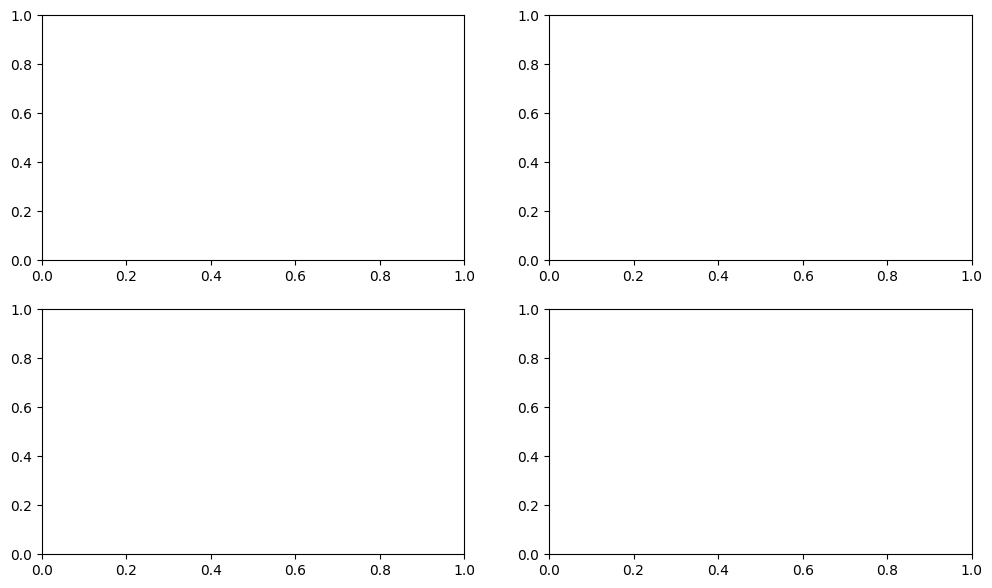

In [168]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(12, 7))

